# Import Packages

In [12]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import sys
import os
# import math

import seaborn as sns
sns.set_style('white')
sns.set_context("paper")

# from scipy.optimize import curve_fit

# Gaussian Processes
import gpflow
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float
from gpflow.utilities import set_trainable

# Tensorflow
import tensorflow as tf
import tensorflow_probability as tfp

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

from ev_forecasting_package.data_processing.VehicleRegistrationDataProcessing import VehicleStockModelDataPrepper
from ev_forecasting_package.models.VehicleStockDynamics import VehicleStockDynamicsInferenceModel
from ev_forecasting_package.models.EVForecastingModel import GLGModel, CustomMeanFunction, EVForecastingModel
from ev_forecasting_package.models.EVForecastingModel import probit, invprobit

# Preparing Training Data

We want to model four key variables using four individual Gaussian process (GP) models. These variables include:
- EV share of vehicle additions ($a$)
- BEV share of EV additions ($b$)
- Vehicle additions ($A_\text{Vehicles}$)
- Vehicle removals ($R_\text{Vehicles}$)

These variables can be described using time series data.

In this example, we use data for Lower Layer Super Output Areas (LSOAs) in the Bath and North East Somerset (BANES) Local Authority District (LAD) in the UK. 

BANES contains 115 LSOAs.

### Prepare the vehicle stock model data

The `prepare_data` method allows you to take a subset of LSOAs using the argument: `lsoa_subset`.

`t_0` represents the first year with complete data accross all raw and processed variable (`additions_eng` has no data for 2011 as it's calculated from differences between sequential years.)

`t_0_raw` represents the first year with complete data accross all raw variables.

`t_n` is the "current" year.

We use the `VehicleStockModelDataPrepper` class to prepare the training data that has been previously generated and processed using other classes within the `VehicleRegistrationDataProcessing.py` module.

In [2]:
vehicle_stock_model_data_prepper = VehicleStockModelDataPrepper()
year_quarter = '2023_Q4'
file_names = {
    'stock_eng': f'stock_df_{year_quarter}.csv',
    'additions_eng': f'sales_df_{year_quarter}.csv',
    'v_lsoa': f'v_lsoa_{year_quarter}.csv',
    'icev_lsoa': f'icev_lsoa_{year_quarter}.csv',
    'ev_lsoa': f'ev_lsoa_{year_quarter}.csv',
    'bev_lsoa': f'bev_lsoa_{year_quarter}.csv',
    'phev_lsoa': f'phev_lsoa_{year_quarter}.csv'
}
vehicle_stock_model_data_prepper.prepare_data(
    data_path='../data/large_datasets/vehicle_registrations/processed_data', 
    file_names=file_names, 
    lsoa_subset=115, 
    t_0=2012, # 
    t_0_raw=2011, 
    t_n=2023
)

### Generate LSOA-indexed data from "annual_data_dict"

We create a dictionary of Pandas DataFrames called `data_dict` where we will eventually add the posterior means of the inferred vehicle stock dynamics.

We alse create a list of LSOA indexes called `lsoa_idxs` for convenient indexing.

In [4]:
data_dict = {}
lsoa_idxs = vehicle_stock_model_data_prepper.annual_data_dict['v_lsoa'].columns
for vehicle_type in ['v_lsoa', 'icev_lsoa', 'ev_lsoa', 'bev_lsoa', 'phev_lsoa', 'ev_market_share', 'bev_market_share', 'phev_market_share']:
    for lsoa in lsoa_idxs:
        if lsoa not in data_dict:
            data_dict[lsoa] = pd.DataFrame()
        data_dict[lsoa][vehicle_type] = vehicle_stock_model_data_prepper.annual_data_dict[vehicle_type][lsoa]

data_dict[lsoa_idxs[0]]

,v_lsoa,icev_lsoa,ev_lsoa,bev_lsoa,phev_lsoa,ev_market_share,bev_market_share,phev_market_share
Year,,,,,,,,
2011,391.0,391.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2012,386.0,386.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2013,369.0,369.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2014,362.0,362.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2015,356.0,356.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2016,356.0,355.0,1.0,1.0,0.0,0.002809,0.002809,0.000000
2017,358.0,356.0,2.0,2.0,0.0,0.005587,0.005587,0.000000
2018,368.0,366.0,3.0,3.0,0.0,0.008152,0.008152,0.000000
2019,364.0,360.0,4.0,4.0,0.0,0.010989,0.010989,0.000000


### Build the vehicle stock dynamics inference model

To create an instance of VehicleStockDynamicsInferenceModel, we must give it a dictionary containing all of the model variables and historical annualised data.

In [5]:
vehicle_stock_dynamics_inference_model = VehicleStockDynamicsInferenceModel(
    model_variables_dict=vehicle_stock_model_data_prepper.model_variables_dict, 
    annual_data_dict=vehicle_stock_model_data_prepper.annual_data_dict, 
    lsoa_idxs=vehicle_stock_model_data_prepper.lsoa_subset
)

vehicle_stock_dynamics_inference_model.build_model()

Model built successfully


### Load pre-run MCMC trace

In [6]:
vehicle_stock_dynamics_inference_model.load_trace('vehicle_stock_dynamics_model_banes_trace.nc')

Trace loaded from vehicle_stock_dynamics_model_banes_trace.nc


### Extract posterior means from loaded trace

In [7]:
posterior_means = vehicle_stock_dynamics_inference_model.calculate_posterior_means()

Posterior means calculated successfully


### Add posterior means to `data_dict`

Add posterior means of the four variables to be forecasted to the data dictionary containing historical data for vehicle registrations.

In [9]:
for key in posterior_means.keys():
    for lsoa in lsoa_idxs:
        data_dict[lsoa][key] = posterior_means[key][lsoa]

data_dict[lsoa_idxs[0]]

,v_lsoa,icev_lsoa,ev_lsoa,bev_lsoa,phev_lsoa,ev_market_share,bev_market_share,phev_market_share,A_vehicles,R_vehicles,A_ev,R_ev,A_bev,R_bev,A_phev,R_phev,a,b,1 - b
Year,,,,,,,,,,,,,,,,,,,
2011,391.0,391.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,386.0,386.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,16.75,21.75,0.062515,0.000000,0.031775,0.000000,0.030740,0.000000,0.003883,0.504743,0.495257
2013,369.0,369.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,14.25,31.25,0.061607,0.000000,0.031635,0.000000,0.029972,0.000000,0.004836,0.506840,0.493160
2014,362.0,362.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,18.25,25.25,0.062146,0.000000,0.030801,0.000000,0.031345,0.000000,0.003499,0.494931,0.505069
2015,356.0,356.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,22.25,28.25,0.061711,0.000000,0.030472,0.000000,0.031238,0.000000,0.002796,0.496227,0.503773
2016,356.0,355.0,1.0,1.0,0.0,0.002809,0.002809,0.000000,21.50,21.50,1.086745,0.060393,1.023015,0.060393,0.063730,0.000000,0.051072,0.941975,0.058025
2017,358.0,356.0,2.0,2.0,0.0,0.005587,0.005587,0.000000,21.00,19.00,1.132853,0.106145,1.069082,0.106145,0.063772,0.000000,0.054561,0.944319,0.055681
2018,368.0,366.0,3.0,3.0,0.0,0.008152,0.008152,0.000000,22.75,12.75,1.130339,0.103940,1.066106,0.103940,0.064232,0.000000,0.049853,0.943844,0.056156
2019,364.0,360.0,4.0,4.0,0.0,0.010989,0.010989,0.000000,18.25,22.25,1.270816,0.244505,1.207551,0.244505,0.063265,0.000000,0.070183,0.950696,0.049304


# Custom Mean Functions

Here we use a generalise logistic growth (GLG) model for the mean function of the EV share of vehicle additions ($a$) variable. The GLG function is pretty flexible and can accommodate a wide range of potential scenarios, as demonstrated below.

/Users/isaacflower/Library/CloudStorage/OneDrive-UniversityofBath/Documents/PostDoc/EVForecastingTool/ev_forecasting_package/models/EVForecastingModel.py:87: RuntimeWarning: invalid value encountered in power
  return A + ((K - A) / (C + Q * np.exp(-B * (x - M))) ** (1 / v))


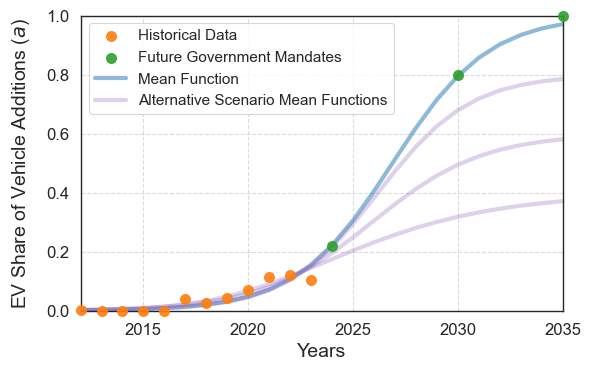

In [8]:
# Dummy data for plotting - replace with actual data from your model
t_h = 2035
t_n = 2023
t_present = 2024
lsoa_idx = lsoa_idxs[3]  # Placeholder, replace with your data

# Replace 'posterior_means' with your actual dataset
test_data_1 = pd.Series(index=np.arange(2012, t_n+1), data=posterior_means['a'].loc[2012:t_n, lsoa_idx].values)
test_data_2 = pd.Series(index=np.arange(2012, t_n+1), data=posterior_means['a'].loc[2012:t_n, lsoa_idx].values)
test_data_3 = pd.Series(index=np.arange(2012, t_n+1), data=posterior_means['a'].loc[2012:t_n, lsoa_idx].values)
test_data_4 = pd.Series(index=np.arange(2012, t_n+1), data=posterior_means['a'].loc[2012:t_n, lsoa_idx].values)

test_data_1[2024] = 0.22
test_data_1[2030] = 0.8
test_data_1[2035] = 1

test_data_2[2024] = 0.2
test_data_2[2030] = 0.7
test_data_2[2035] = 0.8

test_data_3[2024] = 0.2
test_data_3[2030] = 0.5
test_data_3[2035] = 0.6

test_data_4[2024] = 0.2
test_data_4[2030] = 0.3
test_data_4[2035] = 0.4

glg_model_test_1 = GLGModel(data=test_data_1)
glg_model_test_1.fit(t_0=2012, t_n=t_n, p0=[1, 1, 1, 0.3])
glg_model_test_1.project(t_0=2012, t_n=t_n, t_h=t_h)

glg_model_test_2 = GLGModel(data=test_data_2)
glg_model_test_2.fit(t_0=2012, t_n=t_n, p0=[1, 1, 1, 0.3])
glg_model_test_2.project(t_0=2012, t_n=t_n, t_h=t_h)

glg_model_test_3 = GLGModel(data=test_data_3)
glg_model_test_3.fit(t_0=2012, t_n=t_n, p0=[1, 1, 1, 0.3])
glg_model_test_3.project(t_0=2012, t_n=t_n, t_h=t_h)

glg_model_test_4 = GLGModel(data=test_data_4)
glg_model_test_4.fit(t_0=2012, t_n=t_n, p0=[1, 1, 1, 0.3])
glg_model_test_4.project(t_0=2012, t_n=t_n, t_h=t_h)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)

# Plot 1
ax.scatter(x=test_data_1.loc[:2023].index, y=test_data_1.loc[:2023], c='C1', clip_on=False, label='Historical Data', zorder=5, alpha=0.9, s=50)
ax.scatter(x=test_data_1.loc[2024:].index, y=test_data_1.loc[2024:], c='C2', clip_on=False, label='Future Government Mandates', zorder=5, alpha=0.9, s=50)
ax.plot(np.arange(2012, t_h + 1), glg_model_test_1.projection, label='Mean Function', lw=3, alpha=0.5)
ax.set_xlim(2012, t_h)
ax.set_ylim(0, 1)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('EV Share of Vehicle Additions ($a$)', fontsize=14, rotation=90, labelpad=10)
ax.tick_params(labelsize=12)
ax.grid(axis='both', linestyle='--', alpha=0.7)

# Plot 2
ax.plot(np.arange(2012, t_h + 1), glg_model_test_2.projection, label='Alternative Scenario Mean Functions', lw=3, alpha=0.3, color='C4')

# Plot 3
ax.plot(np.arange(2012, t_h + 1), glg_model_test_3.projection, lw=3, alpha=0.3, color='C4')

# Plot 3
ax.plot(np.arange(2012, t_h + 1), glg_model_test_4.projection, lw=3, alpha=0.3, color='C4')

# Shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=11, bbox_to_anchor=(0.41, 0.9))

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

# Building the Forecasting Model

### Data

Here, we will demonstrate the model on a single LSOA.

In [10]:
idx = 2
data = data_dict[lsoa_idxs[idx]]

We will also set the time horizon parameters as follows

In [11]:
t_dict = {
    't_0': 2012, # Where the training data should start
    't_n': 2020, # Where the training data should end
    't_h': 2035 # How far ahead the model should forecast
}

### Kernel Priors

$a$ kernel

In [13]:
a_rbf_kernel = gpflow.kernels.RBF(
    lengthscales=gpflow.Parameter(f64(3.0), prior=tfp.distributions.Gamma(f64(10.0), f64(2.0)), transform=tfp.bijectors.Softplus()),
    variance=gpflow.Parameter(f64(0.5), prior=tfp.distributions.Gamma(f64(2), f64(1)), transform=tfp.bijectors.Softplus())
)
a_white_kernel = gpflow.kernels.White(variance=0.05)
gpflow.set_trainable(a_white_kernel.variance, False) # Fix variance of white kernel
a_kernel = a_rbf_kernel + a_white_kernel

$b$ kernel

In [14]:
b_rbf_kernel = gpflow.kernels.RBF(
    lengthscales=gpflow.Parameter(f64(3.0), prior=tfp.distributions.Gamma(f64(10.0), f64(2.0)), transform=tfp.bijectors.Softplus()),
    variance=gpflow.Parameter(f64(0.5), prior=tfp.distributions.Gamma(f64(2), f64(0.25)), transform=tfp.bijectors.Softplus())
)
b_white_kernel = gpflow.kernels.White(variance=0.05)
gpflow.set_trainable(b_white_kernel.variance, False) # Fix variance of white kernel
b_kernel = b_rbf_kernel + b_white_kernel

$A$ kernel

In [15]:
A_rbf_kernel = gpflow.kernels.RBF(
    lengthscales=gpflow.Parameter(f64(3.0), prior=tfp.distributions.Gamma(f64(10.0), f64(2.0)), transform=tfp.bijectors.Softplus()),
    variance=gpflow.Parameter(f64(0.5), prior=tfp.distributions.Uniform(low=tf.cast(0.05, tf.float64), high=tf.cast(10, tf.float64)), transform=tfp.bijectors.Softplus())
)
A_white_kernel = gpflow.kernels.White(variance=f64(0.01))
A_kernel = A_rbf_kernel + A_white_kernel

$R$ kernel

In [16]:
R_rbf_kernel = gpflow.kernels.RBF(
    lengthscales=gpflow.Parameter(f64(3.0), prior=tfp.distributions.Gamma(f64(10.0), f64(2.0)), transform=tfp.bijectors.Softplus()),
    variance=gpflow.Parameter(f64(0.5), prior=tfp.distributions.Uniform(low=tf.cast(0.05, tf.float64), high=tf.cast(10, tf.float64)), transform=tfp.bijectors.Softplus())
)
R_white_kernel = gpflow.kernels.White(variance=f64(0.01))
R_kernel = R_rbf_kernel + R_white_kernel

Create a kernel dictionary

In [17]:
kernels_dict = {
    'a': a_kernel,
    'b': b_kernel,
    'A_vehicles': A_kernel,
    'R_vehicles': R_kernel
}

### Mean Functions

$a$ mean function

In [20]:
t_0=t_dict['t_0']
t_n=t_dict['t_n']
t_h=t_dict['t_h']

govermnent_mandates = {
    2024: 0.22,
    2030: 0.8,
    2035: 1,
}

X = data['a'].loc[t_0:t_n].index.values.reshape(-1, 1)
Y = data['a'].loc[t_0:t_n].values.reshape(-1, 1)
training_data = pd.Series(index=X.flatten(), data=Y.flatten())

# Incorporate Government Mandates
for year, value in govermnent_mandates.items():
    training_data[year] = value

glg_model = GLGModel(data=training_data)
glg_model.fit(t_0=t_0, t_n=t_n, p0=[1, 1, 1, 0.3])
glg_model.project(t_0=t_0, t_n=t_n, t_h=t_h)
a_mean_function = CustomMeanFunction(glg_model)

$b$ mean function

In [19]:
if (data['a'].loc[:t_n] > 0).sum() > 0:
    first_non_zero_year = data['a'][data['a'] > 0].index[0]
else:
    first_non_zero_year = t_0

constant_mean = f64(data['b'].loc[first_non_zero_year:t_n].mean() + 0.5*(1 - data['b'].loc[first_non_zero_year:t_n].mean()))
b_mean_function = gpflow.functions.Constant(probit(constant_mean))

$A$ mean function

In [18]:
A_mean_function = gpflow.functions.Constant(f64(np.log(data['A_vehicles'].mean())))

$R$ mean function

In [21]:
R_mean_function = gpflow.functions.Constant(f64(np.log(data['R_vehicles'].mean())))

Combine mean functions into dictionary

In [22]:
mean_functions_dict = {
    'a': a_mean_function,
    'b': b_mean_function,
    'A_vehicles': A_mean_function,
    'R_vehicles': R_mean_function
}

### Likelihood Priors

In [23]:
a_likelihood = None # Gaussian (Probit transformed)
b_likelihood = gpflow.likelihoods.Beta() # Continuous and constrained between 0 and 1
A_likelihood = gpflow.likelihoods.Poisson() # Count variable (Positive integer)
R_likelihood = gpflow.likelihoods.Poisson() # Count variable (Positive integer)

likelihoods_dict = {
    'a': a_likelihood,
    'b': b_likelihood,
    'A_vehicles': A_likelihood,
    'R_vehicles': R_likelihood
}

### Initialising the forecasting model

In [24]:
ev_forecasting_model = EVForecastingModel(
    lsoa_idx=lsoa_idxs[idx],
    data=data,
    kernels=kernels_dict,
    mean_functions=mean_functions_dict,
    likelihoods=likelihoods_dict,
    t=t_dict
)

GP training data prepared successfully
GP models constructed successfully


# Forecasting using the model

### Train the models, sample from them and generate forecasts

In [26]:
ev_forecasting_model.train_models()
ev_forecasting_model.generate_f_samples(return_dict=False, n_samples=1000)
ev_forecasting_model.generate_forecasts()

GP for variable: a trained successfully
GP for variable: b trained successfully
GP for variable: A trained successfully
GP for variable: R trained successfully
1000 samples taken from each GP model.
Forecasts generated successfully.


### Plotting forecasts

Using the in-built plotting function in the EVForecastingModel and wrapping this in a convenience function to plot forecasts for multiple variables.

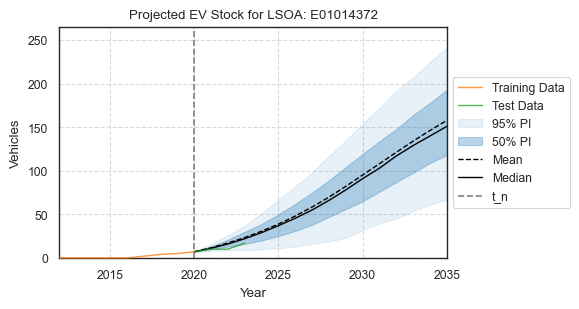

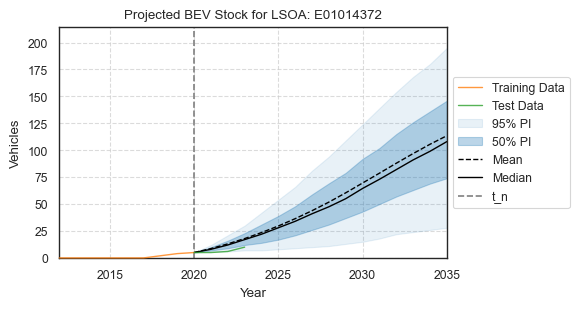

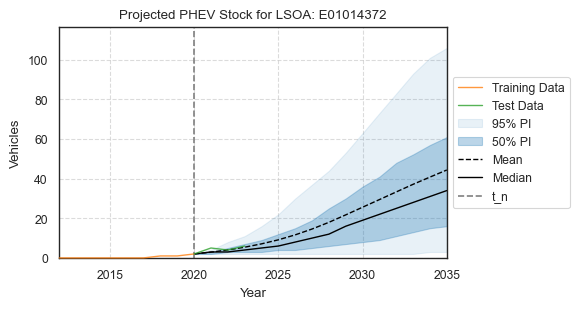

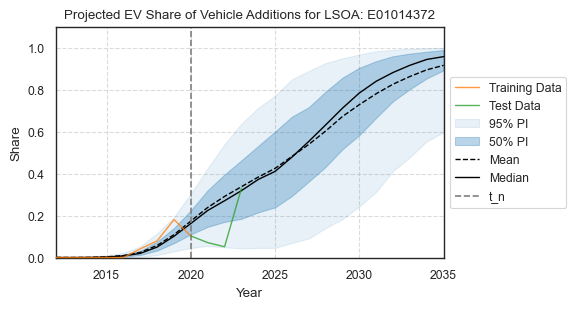

In [27]:
def plot_forecasts(ev_stock_model, variables):
    for variable_name in variables:
        ev_stock_model.plot_forecast(variable_name=variable_name)

plot_forecasts(
    ev_stock_model=ev_forecasting_model,
    variables=['EV', 'BEV', 'PHEV', 'a']
)